# TREC

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gensim.downloader
import time

In [2]:
# Load training and development datasets
df_train=pd.read_csv("../datasets/TREC/train.csv")
df_train["text"] = df_train["text"].str.lower()

# Load test dataset
df_test=pd.read_csv("../datasets/TREC/test.csv")
df_test["text"] = df_test["text"].str.lower()

In [3]:
# Split the training dataset to create a development set of 500 examples
train_data, dev_data = train_test_split(df_train, test_size=500, random_state=42)

# Rename the test dataset to synchronize the namings
test_data = df_test

len(train_data), len(dev_data), len(test_data)

(4952, 500, 500)

## Update Word2Vec

In [4]:
# Download the "glove-twitter-25" embeddings
w2v = gensim.downloader.load('word2vec-google-news-300')

In [5]:
# Out-of-vocabulary (OOV) words
# 1. can be replaced with a special token, such as "<OOV>" or "<UNK>"
# 2. can be ignored

word2idx = w2v.key_to_index

# Add '<UNK>' and '<PAD>' tokens to the vocabulary index
word2idx['<UNK>'] = len(word2idx)
word2idx['<PAD>'] = len(word2idx)

print(f"word2idx['<UNK>']: {word2idx['<UNK>']}")
print(f"word2idx['<PAD>']: {word2idx['<PAD>']}")

word2idx['<UNK>']: 3000000
word2idx['<PAD>']: 3000001


In [6]:
# Add the '<UNK>' word to the vocabulary of the Word2Vec model 
# Initialize it with the average of all word vectors int he pretrained embeddings
unk_vector = np.mean(w2v.vectors, axis=0)
w2v.vectors = np.vstack([w2v.vectors, unk_vector])
print("after insert UNK: ", w2v.vectors.shape)

# Add the '<PAD>' word to the vocabulary of the Word2Vec model 
# Initialize it with a row of zeros in the vectors matrix
w2v.vectors = np.vstack([w2v.vectors, np.zeros(w2v.vectors[0].shape)])
print("after insert UNK: ", w2v.vectors.shape)

after insert UNK:  (3000001, 300)
after insert UNK:  (3000002, 300)


## Modify Class Labels

In [7]:
# Get unique coarse labels
unique_labels = train_data['label-coarse'].unique()

# Randomly select 4 classes
np.random.seed(19260817)
selected_labels = np.random.choice(unique_labels, size=4, replace=False)

# ****** 6 == OTHERS !!!!!! IMPORTANT 
# update: 6 will cause error, change back to OTHERS then transform later

train_data['new_label'] = train_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
dev_data['new_label'] = dev_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
test_data['new_label'] = test_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")

# Display the unique labels in the updated training set
train_data['new_label'].unique()

array([2, 0, 'OTHERS', 4, 3], dtype=object)

In [8]:
# Encode labels for easier reference in the following part
label_encoder = LabelEncoder()

test_data['new_label'] = test_data['new_label'].astype(str)
test_data["label_transformed"] = label_encoder.fit_transform(test_data['new_label'])

train_data['new_label'] = train_data['new_label'].astype(str)
train_data["label_transformed"] = label_encoder.fit_transform(train_data['new_label'])

dev_data['new_label'] = dev_data['new_label'].astype(str)
dev_data["label_transformed"] = label_encoder.fit_transform(dev_data['new_label'])

In [9]:
train_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
4943,2,34,what is mikhail gorbachev 's middle initial ?,2,1
2346,0,0,how does the tail affect the flight of a kite ?,0,0
1835,5,21,what were the first three cities to have a pop...,OTHERS,4
4047,1,1,what is the movie jonathan livingstone seagull ?,OTHERS,4
5097,1,23,what is a fear of home surroundings ?,OTHERS,4


In [10]:
dev_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
3408,5,21,what city is served by tempelhol airport ?,OTHERS,4
371,1,2,what is dudley do-right 's horse 's name ?,OTHERS,4
453,0,9,what 's nature 's purpose for tornadoes ?,0,0
290,0,12,what is the history of valentine 's day cards ?,0,0
4457,3,4,what president became chief justice after his ...,3,2


In [11]:
test_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
0,4,40,how far is it from denver to aspen ?,4,3
1,5,21,"what county is modesto , california in ?",OTHERS,4
2,3,12,who was galileo ?,3,2
3,0,7,what is an atom ?,0,0
4,4,8,when did hawaii become a state ?,4,3


## Handle Out of Vocabulary and Pad Sentence (i.e. Add \<UNK> && \<PAD>)

In [12]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

def sentence_to_indices(sentence, vocab):
    return [vocab.get(word, vocab.get('<UNK>')) for word in sentence]

class TRECDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = [torch.tensor(sentence_to_indices(sentence, vocab)) for sentence in sentences]
        self.labels = [torch.tensor(label) for label in labels]
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

def collate_fn(batch):
    sentences, labels = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=word2idx['<PAD>'])
    return sentences_padded, labels

# Create PyTorch datasets and data loaders
train_dataset = TRECDataset(train_data['text'], train_data['label_transformed'], word2idx)
dev_dataset = TRECDataset(dev_data['text'], dev_data['label_transformed'], word2idx)
test_dataset = TRECDataset(test_data['text'], test_data['label_transformed'], word2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Training, Evaluation and Visualization function

**Since Dataloader is fixed, try to use below functions for easy-training-implementation**

In [13]:
from sklearn.metrics import f1_score

In [14]:
def train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience):
    train_losses = []
    dev_losses = []
    train_accuracies = []
    dev_accuracies = []
    y_true = []
    y_pred = []
    best_accuracy = 0.0
    no_improvement_count = 0
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for sentences, label_tuple in train_loader:
            model.zero_grad()
            labels = torch.stack(label_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracies.append(100 * correct / total)
        train_losses.append(total_loss/len(train_loader))
        
        # Validation loop
        model.eval()
        dev_loss = 0
        correct_dev = 0
        total_dev = 0
        with torch.no_grad():
            for sentences, label_tuple in dev_loader:
                labels = torch.stack(label_tuple)
                predictions = model(sentences)
                
                loss = loss_function(predictions, labels)
                dev_loss += loss.item()
                
                _, predicted = torch.max(predictions, 1)
                total_dev += labels.size(0)
                correct_dev += (predicted == labels).sum().item()
                
                y_true.extend(labels)
                y_pred.extend(predicted)
        
        dev_accuracy = 100 * correct_dev / total_dev
        dev_accuracies.append(dev_accuracy)
        dev_losses.append(dev_loss/len(dev_loader))
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Dev Loss: {dev_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Dev Accuracy: {dev_accuracies[-1]:.2f}%")
        
        # Compute F1 score
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_micro = f1_score(y_true, y_pred, average='micro')
        print("Macro F1 Score:", f1_macro)
        print("Micro F1 Score:", f1_micro)
        
        # Early stopping
        if dev_accuracy > best_accuracy:
            best_accuracy = dev_accuracy
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f'Early stopping after {epoch+1} epochs with no improvement.')

            end_time = time.time()
            total_train_time = end_time - start_time
            print(f'Total training time: {total_train_time:.2f} seconds.')
            break
    
    end_time = time.time()
    total_train_time = end_time - start_time
    print(f'Total training time: {total_train_time:.2f} seconds.')

    return train_losses, dev_losses, train_accuracies, dev_accuracies

In [15]:
def evaluate_model(model, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    y_true_test = []
    y_pred_test = []
    
    with torch.no_grad():
        for sentences, tag_tuple in test_loader:
            labels = torch.stack(tag_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            y_true_test.extend(labels)
            y_pred_test.extend(predicted)

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # Compute F1 score
    f1_test_macro = f1_score(y_true_test, y_pred_test, average='macro')
    f1_test_micro = f1_score(y_true_test, y_pred_test, average='micro')
    print("Macro F1 Score on Test Set:", f1_test_macro)
    print("Micro F1 Score on Test Set:", f1_test_micro)

    return test_loss, test_accuracy

In [16]:
def visualize(train_losses, dev_losses, train_accuracies, dev_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, dev_losses, 'r*-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, dev_accuracies, 'r*-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [17]:
# Load embedding layer
weights = torch.FloatTensor(w2v.vectors)

# Build nn.Embedding() layer
embedding = nn.Embedding.from_pretrained(weights)
# embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=vocab.get('<PAD>', None), freeze=True)
embedding.requires_grad = False

embedding_matrix = torch.FloatTensor(w2v.vectors)

## Model 1
Hidden layer: Simple linear layer\
Aggregation Method: Average pooling over the word vectors

In [18]:
# Define model 1 architecture
class QuestionClassifierModel1(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(QuestionClassifierModel1, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,  padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)

        # Aggregation Layer: Averaging word vectors across sequence length
        x = torch.mean(x, dim=1)  # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [20]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5

model = QuestionClassifierModel1(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 150
patience = 10

In [21]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/150, Train Loss: 1.4058, Dev Loss: 1.3838, Train Accuracy: 37.88%, Dev Accuracy: 39.00%
Macro F1 Score: 0.11223021582733812
Micro F1 Score: 0.39
Epoch 2/150, Train Loss: 1.3616, Dev Loss: 1.3690, Train Accuracy: 39.16%, Dev Accuracy: 43.00%
Macro F1 Score: 0.16414688177598258
Micro F1 Score: 0.41
Epoch 3/150, Train Loss: 1.3497, Dev Loss: 1.3626, Train Accuracy: 40.87%, Dev Accuracy: 43.00%
Macro F1 Score: 0.17915522620904836
Micro F1 Score: 0.4166666666666667
Epoch 4/150, Train Loss: 1.3398, Dev Loss: 1.3578, Train Accuracy: 40.87%, Dev Accuracy: 42.60%
Macro F1 Score: 0.1856912107038246
Micro F1 Score: 0.419
Epoch 5/150, Train Loss: 1.3346, Dev Loss: 1.3507, Train Accuracy: 41.58%, Dev Accuracy: 41.80%
Macro F1 Score: 0.18800201705945463
Micro F1 Score: 0.4188
Epoch 6/150, Train Loss: 1.3247, Dev Loss: 1.3456, Train Accuracy: 42.23%, Dev Accuracy: 41.60%
Macro F1 Score: 0.18943739123715744
Micro F1 Score: 0.41833333333333333
Epoch 7/150, Train Loss: 1.3146, Dev Loss: 1.3517, 

In [27]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.2727, Test Accuracy: 42.80%
Macro F1 Score on Test Set: 0.278449633247375
Micro F1 Score on Test Set: 0.428


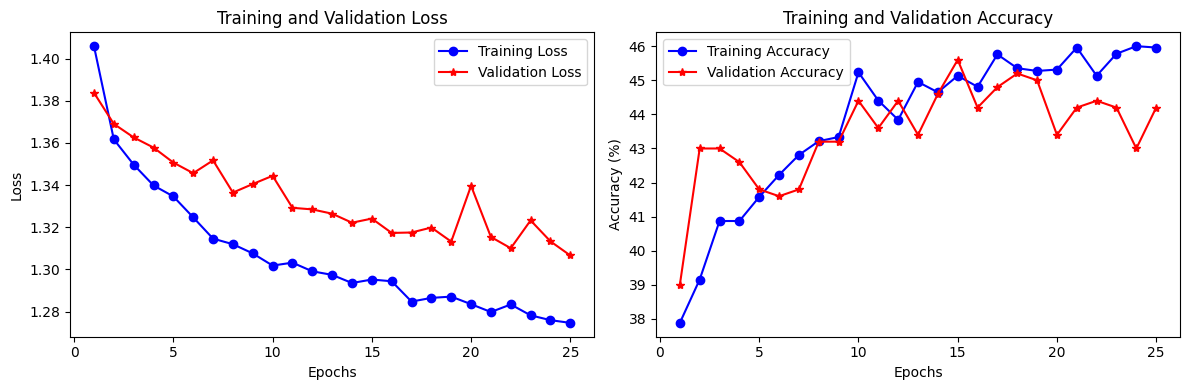

In [28]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 2
Hidden Layer Design: Simple linear layer\
Aggregation Method: Max pooling over the word vectors

In [29]:
# Define model 2 architecture
class QuestionClassifierModel2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, sample_percent):
        super(QuestionClassifierModel2, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,  padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
        
        self.sample_percent = sample_percent
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)
        
        # Aggregation Layer: Max pooling over the word vectors
        sentence_len = list(x.size())[1]
        x = torch.flatten(x, start_dim=1)
        max_pooling = nn.MaxPool1d(sentence_len, stride=sentence_len)
        x = max_pooling(x) # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim

        return x

In [34]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
MAX_POOLING_SAMPLE_PERCENT = 0.8

model = QuestionClassifierModel2(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, MAX_POOLING_SAMPLE_PERCENT)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
patience = 20

In [35]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/100, Train Loss: 1.3791, Dev Loss: 1.3368, Train Accuracy: 38.11%, Dev Accuracy: 42.00%
Macro F1 Score: 0.23579078853142227
Micro F1 Score: 0.41999999999999993
Epoch 2/100, Train Loss: 1.2754, Dev Loss: 1.2723, Train Accuracy: 45.86%, Dev Accuracy: 45.80%
Macro F1 Score: 0.27325156810035844
Micro F1 Score: 0.439
Epoch 3/100, Train Loss: 1.2049, Dev Loss: 1.2488, Train Accuracy: 51.45%, Dev Accuracy: 50.80%
Macro F1 Score: 0.3149206382247153
Micro F1 Score: 0.462
Epoch 4/100, Train Loss: 1.1441, Dev Loss: 1.1989, Train Accuracy: 55.63%, Dev Accuracy: 52.20%
Macro F1 Score: 0.3362027145046992
Micro F1 Score: 0.477
Epoch 5/100, Train Loss: 1.1019, Dev Loss: 1.1872, Train Accuracy: 57.41%, Dev Accuracy: 55.20%
Macro F1 Score: 0.35479468343397547
Micro F1 Score: 0.492
Epoch 6/100, Train Loss: 1.0869, Dev Loss: 1.1809, Train Accuracy: 58.08%, Dev Accuracy: 54.80%
Macro F1 Score: 0.3629262941882362
Micro F1 Score: 0.5013333333333333
Epoch 7/100, Train Loss: 1.0669, Dev Loss: 1.1779, T

In [39]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.2297, Test Accuracy: 49.20%
Macro F1 Score on Test Set: 0.3658198541049459
Micro F1 Score on Test Set: 0.492


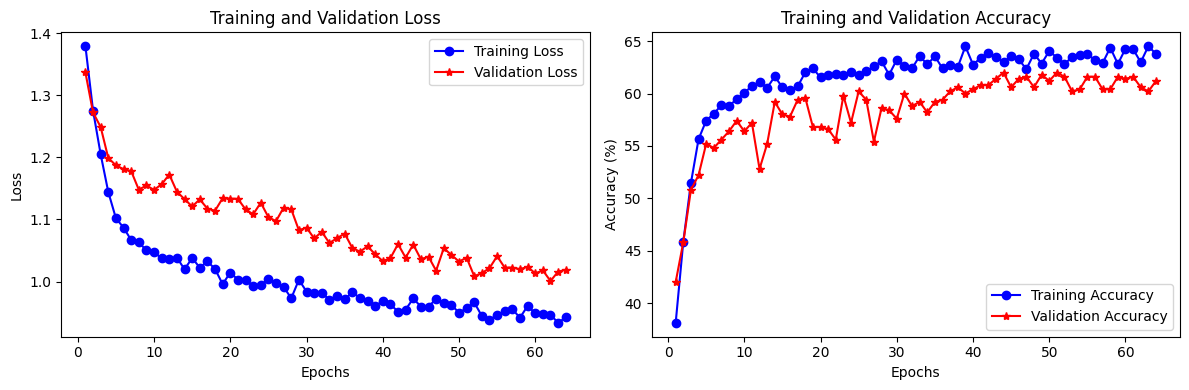

In [38]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 3
Hidden Layer Design: Recurrent neural network (RNN)\
Aggregation Method: Using the representation of the last word (RNN-based)

In [40]:
# Define model 3 architecture
class QuestionClassifierModel3(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel3, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the representation of the last word
        out, hidden = self.hidden(x)
        x = hidden[0] # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [23]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel3(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
patience = 5

In [24]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/50, Train Loss: 1.4099, Dev Loss: 1.4082, Train Accuracy: 37.44%, Dev Accuracy: 38.80%
Macro F1 Score: 0.12903361344537817
Micro F1 Score: 0.388
Epoch 2/50, Train Loss: 1.3955, Dev Loss: 1.4060, Train Accuracy: 38.13%, Dev Accuracy: 39.00%
Macro F1 Score: 0.1246588693957115
Micro F1 Score: 0.389
Epoch 3/50, Train Loss: 1.3942, Dev Loss: 1.4143, Train Accuracy: 38.29%, Dev Accuracy: 38.80%
Macro F1 Score: 0.12616758455921112
Micro F1 Score: 0.38866666666666666
Epoch 4/50, Train Loss: 1.3946, Dev Loss: 1.4148, Train Accuracy: 38.39%, Dev Accuracy: 38.40%
Macro F1 Score: 0.12425299973503919
Micro F1 Score: 0.3875
Epoch 5/50, Train Loss: 1.3931, Dev Loss: 1.4260, Train Accuracy: 38.41%, Dev Accuracy: 38.60%
Macro F1 Score: 0.1232075403353771
Micro F1 Score: 0.38720000000000004
Epoch 6/50, Train Loss: 1.3952, Dev Loss: 1.4132, Train Accuracy: 38.25%, Dev Accuracy: 39.00%
Macro F1 Score: 0.12377379013997936
Micro F1 Score: 0.38766666666666666
Epoch 7/50, Train Loss: 1.3911, Dev Loss:

In [25]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.4446, Test Accuracy: 34.40%
Macro F1 Score on Test Set: 0.10810810810810807
Micro F1 Score on Test Set: 0.344


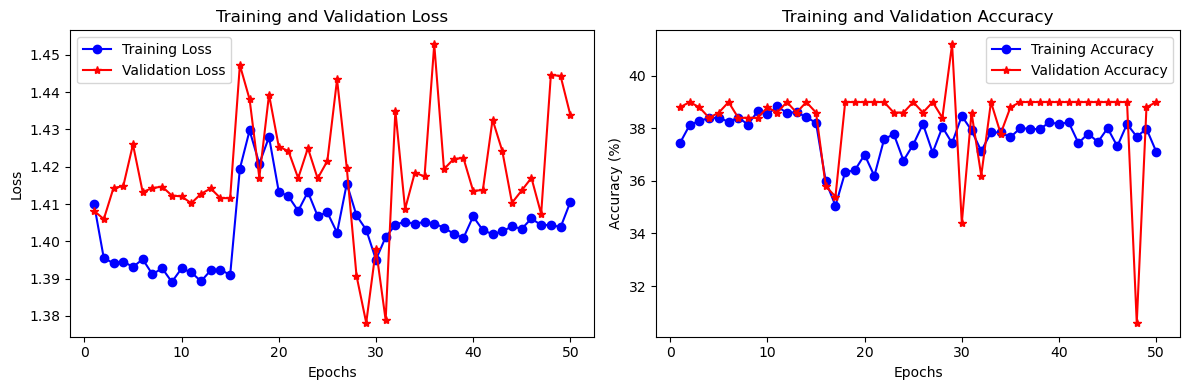

In [26]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 4
Hidden Layer Design: Hierarchical LSTM (LSTM at both word and sentence levels)\
Aggregation Method: Using the representation of the average of all the hidden layers

In [56]:
# Define model 4 architecture
class QuestionClassifierModel4(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel4, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the mean of the hidden layers as the final representation
        out, (hidden, cell) = self.hidden(x)
        x = torch.mean(hidden, dim=0) # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [ ]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel4(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200
patience = 15

In [60]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/100, Train Loss: 0.6908, Dev Loss: 0.6892, Train Accuracy: 73.28%, Dev Accuracy: 73.60%
Macro F1 Score: 0.592024679935094
Micro F1 Score: 0.736
Epoch 2/100, Train Loss: 0.6468, Dev Loss: 0.6699, Train Accuracy: 75.22%, Dev Accuracy: 74.80%
Macro F1 Score: 0.5971320319339966
Micro F1 Score: 0.7419999999999999
Epoch 3/100, Train Loss: 0.6087, Dev Loss: 0.6598, Train Accuracy: 76.60%, Dev Accuracy: 74.60%
Macro F1 Score: 0.597508466543015
Micro F1 Score: 0.7433333333333333
Epoch 4/100, Train Loss: 0.5879, Dev Loss: 0.6556, Train Accuracy: 77.34%, Dev Accuracy: 73.40%
Macro F1 Score: 0.5939697787448251
Micro F1 Score: 0.7410000000000001
Epoch 5/100, Train Loss: 0.5697, Dev Loss: 0.6388, Train Accuracy: 77.95%, Dev Accuracy: 76.00%
Macro F1 Score: 0.598762700823157
Micro F1 Score: 0.7448
Epoch 6/100, Train Loss: 0.5552, Dev Loss: 0.6131, Train Accuracy: 78.72%, Dev Accuracy: 76.20%
Macro F1 Score: 0.6009031944481552
Micro F1 Score: 0.7476666666666666
Epoch 7/100, Train Loss: 0.5312,

In [62]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 0.5612, Test Accuracy: 85.80%
Macro F1 Score on Test Set: 0.8737253986098255
Micro F1 Score on Test Set: 0.858


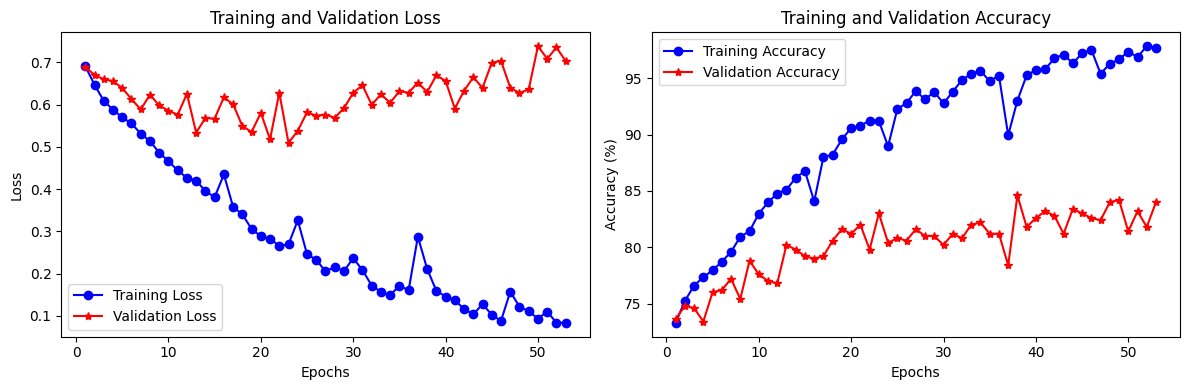

In [63]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 5
Hidden Layer Design: LSTM\
Aggregation Method: Using the last hidden layer as the final representation of the sentence

In [64]:
# Define model 5 architecture
class QuestionClassifierModel5(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel5, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)  # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the last hidden layer as the final representation
        out, (hidden, cell) = self.hidden(x)
        x = hidden[0]  # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [65]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel5(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200
patience = 15

In [66]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/200, Train Loss: 1.4131, Dev Loss: 1.4057, Train Accuracy: 37.58%, Dev Accuracy: 39.00%
Macro F1 Score: 0.11223021582733812
Micro F1 Score: 0.39
Epoch 2/200, Train Loss: 1.3895, Dev Loss: 1.4083, Train Accuracy: 38.57%, Dev Accuracy: 39.00%
Macro F1 Score: 0.12492975690964377
Micro F1 Score: 0.39
Epoch 3/200, Train Loss: 1.3942, Dev Loss: 1.4113, Train Accuracy: 38.19%, Dev Accuracy: 38.80%
Macro F1 Score: 0.1263528963414634
Micro F1 Score: 0.3893333333333333
Epoch 4/200, Train Loss: 1.3850, Dev Loss: 1.4036, Train Accuracy: 38.15%, Dev Accuracy: 37.00%
Macro F1 Score: 0.1564800834153237
Micro F1 Score: 0.3845
Epoch 5/200, Train Loss: 1.3687, Dev Loss: 1.4023, Train Accuracy: 38.71%, Dev Accuracy: 39.00%
Macro F1 Score: 0.1496232648538099
Micro F1 Score: 0.3856
Epoch 6/200, Train Loss: 1.3644, Dev Loss: 1.3634, Train Accuracy: 39.24%, Dev Accuracy: 40.40%
Macro F1 Score: 0.15803972000015787
Micro F1 Score: 0.38866666666666666
Epoch 7/200, Train Loss: 1.3611, Dev Loss: 1.3738, T

In [67]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 0.8267, Test Accuracy: 83.60%
Macro F1 Score on Test Set: 0.833443549121099
Micro F1 Score on Test Set: 0.836


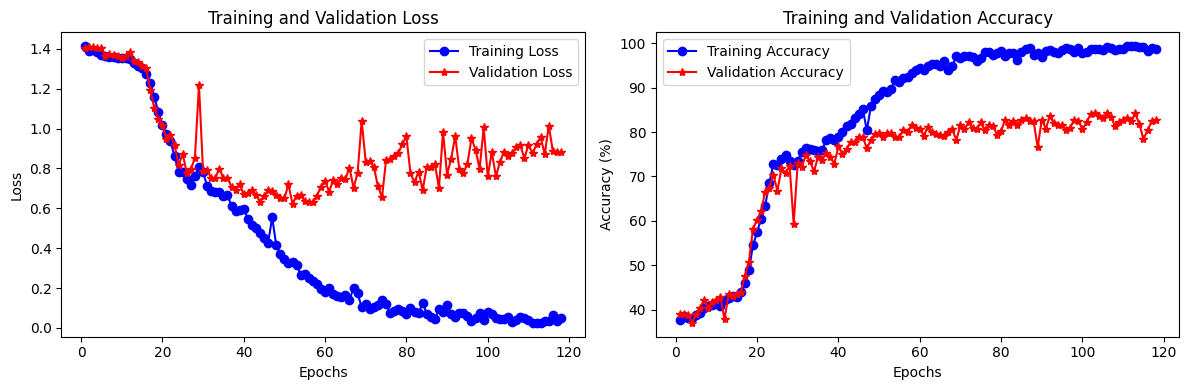

In [68]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 6
Hidden Layer Design: BiLSTM\
Aggregation Method: Using the mean of the two last hidden layers as the final representation

In [69]:
# Define model 6 architecture
class QuestionClassifierModel6(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel6, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, bidirectional=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)  # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the mean of the two last hidden layers as the final representation
        out, (hidden, cell) = self.hidden(x)
        forward_hidden, backward_hidden = hidden.chunk(2, 0)
        average_hidden = torch.mean(torch.cat((forward_hidden, backward_hidden), dim=0), dim=0)
        # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(average_hidden)  # Now, shape: batch_size x output_dim
        
        return x

In [71]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel6(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200
patience = 10

In [72]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/200, Train Loss: 1.2142, Dev Loss: 1.0611, Train Accuracy: 51.19%, Dev Accuracy: 55.40%
Macro F1 Score: 0.35586249437879186
Micro F1 Score: 0.554
Epoch 2/200, Train Loss: 0.9048, Dev Loss: 0.8423, Train Accuracy: 64.01%, Dev Accuracy: 66.40%
Macro F1 Score: 0.45659389984790905
Micro F1 Score: 0.609
Epoch 3/200, Train Loss: 0.7573, Dev Loss: 0.7621, Train Accuracy: 70.38%, Dev Accuracy: 69.80%
Macro F1 Score: 0.4994348614954133
Micro F1 Score: 0.6386666666666667
Epoch 4/200, Train Loss: 0.6859, Dev Loss: 0.7066, Train Accuracy: 73.20%, Dev Accuracy: 71.20%
Macro F1 Score: 0.5208394798030864
Micro F1 Score: 0.657
Epoch 5/200, Train Loss: 0.6383, Dev Loss: 0.7103, Train Accuracy: 75.02%, Dev Accuracy: 73.20%
Macro F1 Score: 0.5344326450347545
Micro F1 Score: 0.672
Epoch 6/200, Train Loss: 0.5959, Dev Loss: 0.6698, Train Accuracy: 76.72%, Dev Accuracy: 73.40%
Macro F1 Score: 0.5512785042733743
Micro F1 Score: 0.6823333333333333
Epoch 7/200, Train Loss: 0.5339, Dev Loss: 0.7122, Tra

In [74]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 0.9649, Test Accuracy: 82.20%
Macro F1 Score on Test Set: 0.8362365700490295
Micro F1 Score on Test Set: 0.822


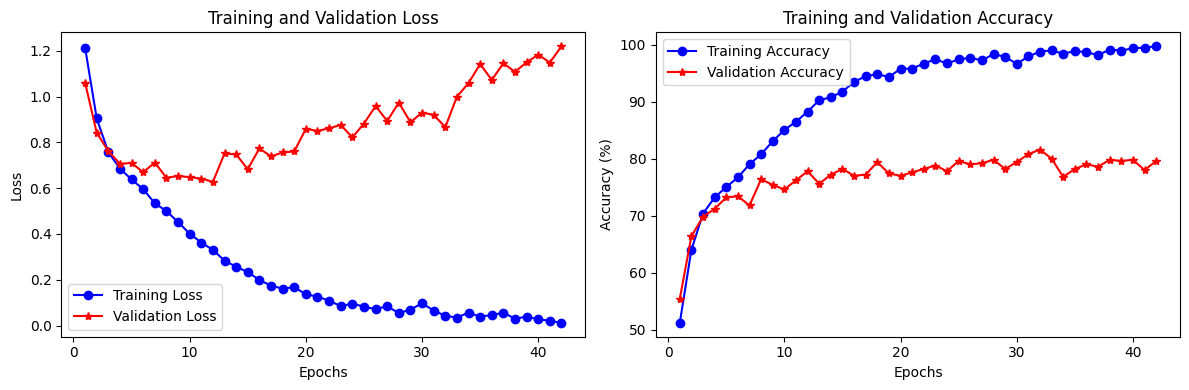

In [75]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 7
Hidden Layer: Transformer Encoder\
Aggregation: Average pooling

In [76]:
# Define model 7 architecture
class QuestionClassifierModel7(nn.Module):
    def __init__(self, embedding_dim, output_dim, num_layers, num_heads, dropout_rate):
        super(QuestionClassifierModel7, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output Layer
        self.output = nn.Linear(embedding_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)  # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Average Pooling
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [35]:
# Define hyperparameters
EMBEDDING_DIM = 300
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 3
NUM_HEADS = 6
DROPOUT_RATE = 0.1

model = QuestionClassifierModel7(EMBEDDING_DIM, LABELSET_SIZE, HIDDEN_LAYERS, NUM_HEADS, DROPOUT_RATE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
num_epochs = 100
patience = 10

In [36]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/100, Train Loss: 1.4010, Dev Loss: 1.3918, Train Accuracy: 38.00%, Dev Accuracy: 42.00%
Macro F1 Score: 0.173651376146789
Micro F1 Score: 0.41999999999999993
Epoch 2/100, Train Loss: 1.3476, Dev Loss: 1.3205, Train Accuracy: 40.49%, Dev Accuracy: 42.80%
Macro F1 Score: 0.18182283407013605
Micro F1 Score: 0.424
Epoch 3/100, Train Loss: 1.2797, Dev Loss: 1.2622, Train Accuracy: 46.30%, Dev Accuracy: 51.40%
Macro F1 Score: 0.2366796755325601
Micro F1 Score: 0.454
Epoch 4/100, Train Loss: 1.2302, Dev Loss: 1.2401, Train Accuracy: 50.57%, Dev Accuracy: 50.40%
Macro F1 Score: 0.2810325486318838
Micro F1 Score: 0.4665
Epoch 5/100, Train Loss: 1.1958, Dev Loss: 1.2312, Train Accuracy: 52.73%, Dev Accuracy: 55.00%
Macro F1 Score: 0.31588945999331325
Micro F1 Score: 0.4832
Epoch 6/100, Train Loss: 1.1652, Dev Loss: 1.1795, Train Accuracy: 55.31%, Dev Accuracy: 57.20%
Macro F1 Score: 0.33859124203430635
Micro F1 Score: 0.498
Epoch 7/100, Train Loss: 1.1384, Dev Loss: 1.1631, Train Accurac

Macro F1 Score: 0.528696389004501
Micro F1 Score: 0.6440392156862745
Epoch 52/100, Train Loss: 0.6984, Dev Loss: 0.7778, Train Accuracy: 73.24%, Dev Accuracy: 71.40%
Macro F1 Score: 0.531390157796512
Micro F1 Score: 0.6453846153846153
Epoch 53/100, Train Loss: 0.6970, Dev Loss: 0.7858, Train Accuracy: 73.00%, Dev Accuracy: 68.80%
Macro F1 Score: 0.5336749810044205
Micro F1 Score: 0.646188679245283
Epoch 54/100, Train Loss: 0.6965, Dev Loss: 0.7675, Train Accuracy: 73.75%, Dev Accuracy: 73.00%
Macro F1 Score: 0.5372130368415479
Micro F1 Score: 0.6477407407407407
Epoch 55/100, Train Loss: 0.6873, Dev Loss: 0.7799, Train Accuracy: 74.05%, Dev Accuracy: 70.20%
Macro F1 Score: 0.5399386653298842
Micro F1 Score: 0.6487272727272727
Epoch 56/100, Train Loss: 0.6939, Dev Loss: 0.7707, Train Accuracy: 73.40%, Dev Accuracy: 70.20%
Macro F1 Score: 0.5432195949515699
Micro F1 Score: 0.6496785714285714
Epoch 57/100, Train Loss: 0.6927, Dev Loss: 0.7647, Train Accuracy: 73.12%, Dev Accuracy: 71.60%
M

In [37]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 0.7434, Test Accuracy: 72.40%
Macro F1 Score on Test Set: 0.7221778018124738
Micro F1 Score on Test Set: 0.724


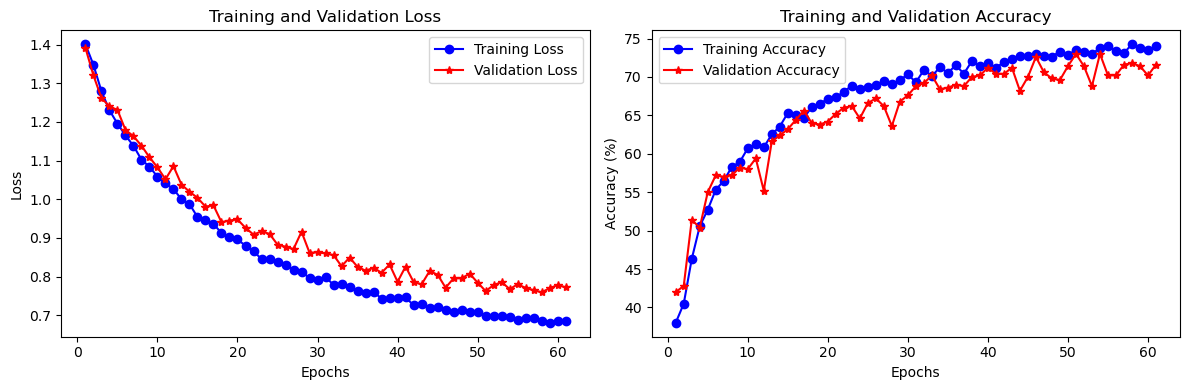

In [38]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)